<a href="https://colab.research.google.com/github/shunitavni/Optimization-algorithms/blob/master/Optimization_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Optimization Algorithms.

here I you will explore and implement different optimization algorithms.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd
import numpy as np

#Data Preparation

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F


# The output of torchvision datasets are PILImage images of range [0, 1].
# PILImage is created by the package Pillow, a python package for image processing.
# https://pillow.readthedocs.io/en/3.1.x/index.html

rawTrain = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

rawTest = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# TODO: Filter the data, keep only planes and frogs.
trainset = list(filter(lambda x : x[1]==0 or x[1] == 6,rawTrain))
testset = list(filter(lambda x : x[1]==0 or x[1] == 6,rawTest))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Use dataloaders for train and test

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

In [ ]:
# Use the following CNN

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # now a few fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# Standard Optimization Algorithms

In this part ill write a few optimization algorithms. All algorithms will be implemented in the same class, with a different procedure. Use member variables to store infomation as needed. The parameters argument, given to the init function, is a dictionary of all parameters provided by calling your module's parameter() method.

In [ ]:
class MyOptimizer(torch.optim.Optimizer):
  def __init__(self, params,lr=0.001, beta1=0.9,eps=1e-8,beta2=0.999):
    defaults = dict(lr=lr,beta1=beta1,eps=eps,beta2=beta2,step = 0);
    super(MyOptimizer, self).__init__(params, defaults)

    self.parameters = params

  def step_sgd(self):
    '''Stochastic gradient descent'''
    for group in self.param_groups:
      # Network-wise
      for p in group['params']:
        # Layer-wise
        if p.grad is not None:
          # Update rule -> X[t+1] = X[t] -lr * df/dX 
          p.data.add_(-group['lr'], p.grad.data)

  def step_sgd_momentum(self):
    '''SGD with momentum'''

    for group in self.param_groups:
      #Network-wise
      for p in group['params']:
        # Layer-wise
        if p.grad is not None:
          # Load the gradients
          grad = p.grad.data;

          # Load the state
          param_state = self.state[p]

          if "Velocity" not in param_state:
            Velocity = param_state['Velocity'] = torch.zeros_like(grad)

          Velocity = param_state['Velocity']
          Velocity.mul_(group['beta1']).add_(grad)

          p.data.add_( -group['lr'] ,  Velocity)

  def step_rmsprop(self):
    '''RMSProp'''
    for group in self.param_groups:
      for p in group['params']:
        if p.grad is not None:
          grad = p.grad.data;
          param_state = self.state[p]
          if "Velocity" not in param_state:
            param_state['Velocity'] = torch.zeros_like(grad)

          Velocity = param_state['Velocity']
          Velocity.mul_(group['beta1']).add_((1-group['beta1']),grad**2)

          p.data.add_( -group['lr'] ,  grad.div_(torch.sqrt(Velocity).add_(group['eps'])))


  def step_adam(self):
  #   '''ADAM'''
    for group in self.param_groups:
      # Network-wise

      # Load the step
      step = group['step'];

      # Advance the step
      step += 1;

      for param in group['params']:
        # Layer-wise
        if param.grad is not None:
          # Get the gradient
          grad = param.grad.data;

          # Load the state
          state = self.state[param];

          # Initialize the state
          if(len(state) == 0):

            # Initialize the steps
            state['step'] = 0;

            # Initialize the moving averages
            state['M'] = torch.zeros_like(grad);
            state['V'] = torch.zeros_like(grad);

          # Load the state
          M = state['M'];
          V = state['V'];

          # Load the betas
          beta1 = group['beta1'];
          beta2 = group['beta2'];

          # Corrections
          correction1 = 1 - beta1 ** step;
          correction2 = 1 - beta2 ** step;

          # Roll the averages
          M.mul_(group['beta1']).add_((1-group['beta1']),grad)
          V.mul_(group['beta2']).addcmul_(1 - group['beta2'], grad, grad)

          # Create the normalized coefficients
          mHat = M.div(correction1);
          vHat = V.div(correction2);

          # Create the adjusted rates
          adjustedRates = (group['lr'] / (torch.sqrt(vHat).add_(group['eps'])));

          # Update the weights
          param.data.addcmul_(value=1,tensor1=mHat,tensor2=-adjustedRates)    

# Train and eval
In this part, ill train my network on the training set and eval on the eval set (see previous notebooks for a full training procedure). This time, use my own optimizer. I will train my network 4 times, each time with a different optimizer. The final output is to plot the loss values on both, train and eval, for all 4 optimizers (all 8 curves on the same plot). Run each training for 100 epochs, report train loss every 200 batches, and test loss every epoch.

In [ ]:
import torch.optim as optim
import numpy as np

# Initialize the network
net = CNN();
# Put the network into training mode
net.train();
net.cuda();

# Define the loss functions
criterion = nn.CrossEntropyLoss();

# Define the optimizer
optimizer = MyOptimizer(net.parameters(),lr=0.001, beta1=0.9,beta2=0.999)

# There is a misunderstanding about whether we should print the loss every 200 batches or every batch 200 per epoch.
# I will implement both ways just to be sure


def train(stepFunction,epochs):
  count = 0;
  train_loss = [];
  test_loss = [];

  for epoch in range(epochs):
    batch_loss = [];
    for batch_index, (inputs,labels) in enumerate(trainloader):
        # Increment the count
        count +=1;

        # Zero the gradients
        optimizer.zero_grad();

        inputs,labels = inputs.cuda(),labels.cuda()
        # Forward
        outputs = net(inputs);

        # Loss
        loss = criterion(outputs,labels);

        # Add the batch loss
        # Since we update only every 200 rounds we have no guarantee that the loss will be monotonicly decreasing.
        # to get a monotonicly decreasing loss uncomment the next lines

        #batch_loss.append(loss.item());
        # and comment these lines
        loss_value = loss.item();
        # Every 200th batch (I believe that this is what you meant but you can uncomment the next code to get the other option)
        if(count % 200 == 0):
          print(f"Batch {count}: Loss: {loss_value} ")        

        # Every batch index % 200
        # if(batch_index % 200 == 0):
        #  print(f"Batch {batch_index}: Loss: {loss_value} ")  

        # Add the loss to the mean
        batch_loss.append(loss_value);

        # Derivative the loss with repsect to the weights
        # calculate the grad.
        loss.backward();

        # Use the optimizer to update the gradients
        # only one step of update
        # optimizer.step_adam();
        stepFunction();
    
    train_loss.append(np.mean(batch_loss));
    print(f"Epoch: {epoch} Batch Average Loss: {np.mean(batch_loss)}")  

    # Calculate test loss and add it to the the list.
    running_loss = 0;
    for batch_index, (inputs,labels) in enumerate(testloader):
      with torch.no_grad():
        inputs,labels = inputs.cuda(),labels.cuda()
        outputs = net(inputs);
        loss = criterion(outputs,labels);
        running_loss += loss.item();
    test_loss.append(running_loss/batch_index);
  return train_loss,test_loss;

In [ ]:
metricsList = [];
epochs = 100;
for i in range(4):
  # Restart the network so it wont keep training from where the last optimizer finished.
  net = CNN()
  # Put the network into training mode
  net.train();
  # Move the network to the GPU
  net.cuda();

  # Define the loss functions
  criterion = nn.CrossEntropyLoss();

  # Define the optimizer
  optimizer = MyOptimizer(net.parameters(),lr=0.001, beta1=0.9,beta2=0.999)
  if(i == 0):
    print("-----------------------------------------------------")
    print("             Stochastic Gradient Descent             ")
    print("-----------------------------------------------------")
    metricsList.append(train(optimizer.step_sgd,epochs));
  if(i == 1):
    print("-----------------------------------------------------")
    print("     Stochastic Gradient Descent Momentum            ")
    print("-----------------------------------------------------")
    metricsList.append(train(optimizer.step_sgd_momentum,epochs));
  if(i == 2):
    print("-----------------------------------------------------")
    print("                    RMS-Prop                         ")
    print("-----------------------------------------------------")    
    metricsList.append(train(optimizer.step_rmsprop,epochs));
  if(i == 3):
    print("-----------------------------------------------------")
    print("                    ADAM                             ")
    print("-----------------------------------------------------")      
    metricsList.append(train(optimizer.step_adam,epochs));           

-----------------------------------------------------
             Stochastic Gradient Descent             
-----------------------------------------------------
Batch 200: Loss: 2.2270209789276123 
Epoch: 0 Batch Average Loss: 2.2435881664958623
Batch 400: Loss: 2.118605613708496 
Batch 600: Loss: 2.021172523498535 
Epoch: 1 Batch Average Loss: 2.078476604562217
Batch 800: Loss: 1.9016932249069214 
Epoch: 2 Batch Average Loss: 1.905888905540442
Batch 1000: Loss: 1.7217222452163696 
Batch 1200: Loss: 1.0493751764297485 
Epoch: 3 Batch Average Loss: 1.4595677243254055
Batch 1400: Loss: 0.7064688205718994 
Epoch: 4 Batch Average Loss: 0.7260239204278769
Batch 1600: Loss: 0.6682789921760559 
Batch 1800: Loss: 0.6657461524009705 
Epoch: 5 Batch Average Loss: 0.68654199073109
Batch 2000: Loss: 0.7082556486129761 
Epoch: 6 Batch Average Loss: 0.6760604851923812
Batch 2200: Loss: 0.6957858800888062 
Batch 2400: Loss: 0.6987268328666687 
Epoch: 7 Batch Average Loss: 0.6683387735400337
Batch 26

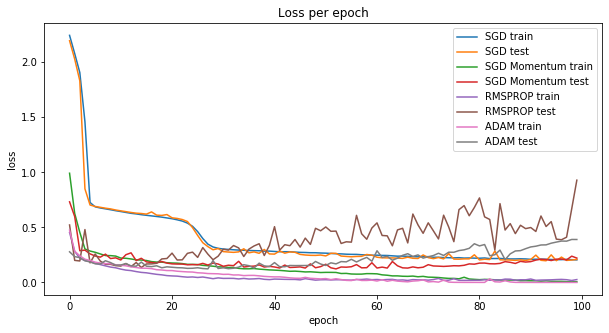

In [ ]:
import matplotlib.pyplot as plt

X = np.arange(0,epochs)
plt.figure(figsize=(10,5))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss per epoch")
names = ["SGD", "SGD Momentum","RMSPROP","ADAM"];
for i in range(4):
  plt.plot(X, metricsList[i][0],label = names[i] + " train")
  plt.plot(X, metricsList[i][1],label = names[i] + " test")

plt.legend(loc='upper right')
plt.show()

# ADAM analysis
One of the complaints about ADAM is that still, the adjusted learning rates (see third math line in https://docs.google.com/presentation/d/1UFmncokDwUC4xLChHOfhe26MJucMyrjPjP9iLcKo30A/edit#slide=id.g5871948b3d_0_86) can be extream (very high or very low). Let's try to confirm this:

Modify your step_adam code to calculate the smallest and largest adjusted rates in the network in every step, and plot that as a curve (X axis is step number, and Y axis is the adjusted LR value). Plot two curves: one for min and one for max. What's your conclusions?

In [ ]:
class MyOptimizer(torch.optim.Optimizer):
  def __init__(self, params,lr=0.0001, beta1=0.9,beta2=0.999,eps=1e-8):
    defaults = dict(lr=lr,beta1=beta1,eps=eps,beta2=beta2,step = 0);
    super(MyOptimizer, self).__init__(params, defaults)
    self.parameters = params
    self.rates = [];
    
  def step_adam(self):
  #   '''ADAM'''
    for group in self.param_groups:
      # Network-wise

      self.network_rates = [];
      # Load the step
      step = group['step'];

      # Advance the step
      step += 1;

      for param in group['params']:
        # Layer-wise
        if param.grad is not None:
          # Get the gradient
          grad = param.grad.data;

          # Load the state
          state = self.state[param];

          # Initialize the state
          if(len(state) == 0):

            # Initialize the steps
            state['step'] = 0;

            # Initialize the moving averages
            state['M'] = torch.zeros_like(grad);
            state['V'] = torch.zeros_like(grad);

          # Load the state
          M = state['M'];
          V = state['V'];

          # Load the betas
          beta1 = group['beta1'];
          beta2 = group['beta2'];

          # Corrections
          correction1 = 1 - beta1 ** step;
          correction2 = 1 - beta2 ** step;

          # Roll the averages
          M.mul_(group['beta1']).add_((1-group['beta1']),grad)
          V.mul_(group['beta2']).addcmul_(1 - group['beta2'], grad, grad)

          # Create the normalized coefficients
          mHat = M.div(correction1);
          vHat = V.div(correction2);

          # Create the adjusted rates
          adjustedRates = (group['lr'] / (torch.sqrt(vHat).add_(group['eps'])));

          maxValue,minValue = torch.max(adjustedRates).item(),torch.min(adjustedRates).item();
          self.network_rates.append(maxValue)
          self.network_rates.append(minValue)

          # Update the weights
          param.data.addcmul_(value=1,tensor1=mHat,tensor2=-adjustedRates)

      self.rates.append([np.max(self.network_rates),np.min(self.network_rates)]);

In [ ]:
# Initialize the network
net = CNN();
# Put the network into training mode
net.train();
net.cuda();

# Define the loss functions
criterion = nn.CrossEntropyLoss();

# Define the optimizer
optimizer = MyOptimizer(net.parameters(),lr=0.0001,beta1=0.9,beta2=0.999)

train(optimizer.step_adam,epochs);

Batch 200: Loss: 0.6785991191864014 
Epoch: 0 Batch Average Loss: 0.8452508297210304
Batch 400: Loss: 0.622499406337738 
Batch 600: Loss: 0.4569382667541504 
Epoch: 1 Batch Average Loss: 0.5139305222148712
Batch 800: Loss: 0.3265567421913147 
Epoch: 2 Batch Average Loss: 0.3674788846851538
Batch 1000: Loss: 0.2646893858909607 
Batch 1200: Loss: 0.35827577114105225 
Epoch: 3 Batch Average Loss: 0.3325408889938848
Batch 1400: Loss: 0.4932650029659271 
Epoch: 4 Batch Average Loss: 0.3228338876852212
Batch 1600: Loss: 0.21971550583839417 
Batch 1800: Loss: 0.3966236412525177 
Epoch: 5 Batch Average Loss: 0.3168214281050923
Batch 2000: Loss: 0.35189783573150635 
Epoch: 6 Batch Average Loss: 0.31294844773249886
Batch 2200: Loss: 0.4324336051940918 
Batch 2400: Loss: 0.19961285591125488 
Epoch: 7 Batch Average Loss: 0.31068378372695116
Batch 2600: Loss: 0.1795855015516281 
Batch 2800: Loss: 0.22185716032981873 
Epoch: 8 Batch Average Loss: 0.30691483873909653
Batch 3000: Loss: 0.3273034691810

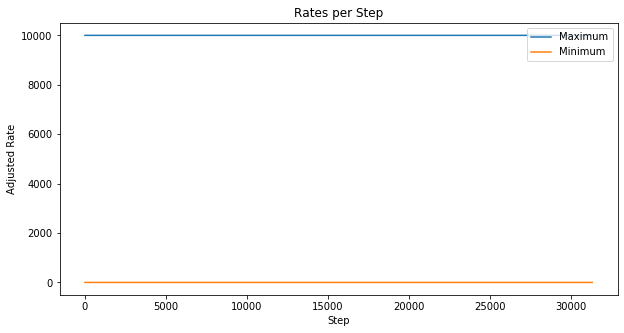

In [ ]:
# The minimal and maximal values of the adjusted rates for every step
values = np.array(optimizer.rates)

# Plot the values
plt.figure(figsize=(10,5))
plt.xlabel('Step')
plt.ylabel('Adjusted Rate')
plt.title("Rates per Step")
plt.plot(values[:,0],label="Maximum");
plt.plot(values[:,1],label="Minimum");
plt.legend(loc='upper right')
plt.show()

**Adjusted Rates**
<br>
We have confirmed that the adjusted learning rates are usually extreme (either very low or very high)



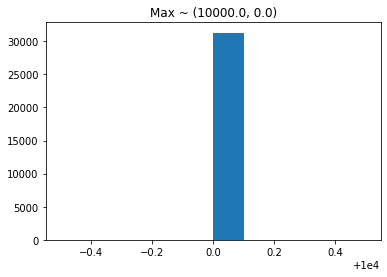

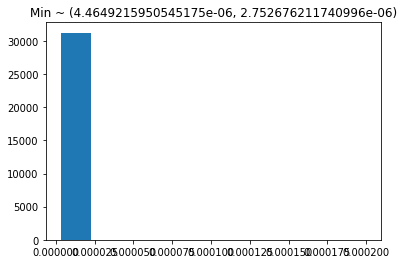

In [ ]:
# Statistics
X_max = np.mean(values[:,0]),np.std(values[:,0])
X_min = np.mean(values[:,1]),np.std(values[:,1])

# Histogram of the Maximum values
plt.title("Max ~ "+str(X_max))
plt.hist(values[:,0])
plt.show()

# Histogram of the Minimum values
plt.title("Min ~ "+str(X_min))
plt.hist(values[:,1])
plt.show()